# Trabalho Prático 2 - Aprendizado de Máquina
## Thiago Pádua de Carvalho - 2020007066

In [146]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.calibration import column_or_1d
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

In [147]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
tic_tac_toe_endgame = fetch_ucirepo(id=101)

# data (as pandas dataframes)
X = tic_tac_toe_endgame.data.features
y = tic_tac_toe_endgame.data.targets

In [162]:
label_encoder = LabelEncoder()

X = X.apply(label_encoder.fit_transform)
y = column_or_1d(y, warn=True)
y = label_encoder.fit_transform(y)
y = y.astype(int)
y = y * 2 - 1  # convert labels to -1, 1 with the objective of making voting easier

In [163]:
def calculateError(weights, y, y_pred):
    return (sum(weights * (np.not_equal(y, y_pred)).astype(int)))/sum(weights)

In [164]:
class AdaBoost:
    def __init__(self, estimator=DecisionTreeClassifier(max_depth=1)):
        self.alphas = []
        self.stumps = []
        self.errors = []
        self.estimator = estimator

    def initializeWeights(self, X):
        """
        Initialize the weights for the AdaBoost algorithm.\n
        wi = 1/N, where N is the number of samples in the dataset.
        """
        self.weights = np.ones(X.shape[0]) / X.shape[0]

    def updateWeights(self, alpha, y, y_pred):
        """
        Update the weights for the AdaBoost algorithm.\n
        """
        self.weights = self.weights * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

    def calculateAlpha(self, error):
        """
        Calculate the alpha value for the AdaBoost algorithm.\n
        """
        alpha = np.log((1 - error) / error)
        return alpha


    def fit(self, X, y, nEstimators=100):
        """
        Fit the AdaBoost classifier to the data.
        """
        self.alphas = []
        self.errors = []
        self.stumps = []
        self.nEstimators = nEstimators

        for i in range(nEstimators):
            if i == 0:
                self.initializeWeights(X)
            else:
                self.updateWeights(alpha_i, y, y_pred)

            h_i = copy.deepcopy(self.estimator)
            h_i.fit(X, y, sample_weight=self.weights)
            y_pred = h_i.predict(X)

            error_i = calculateError(self.weights, y, y_pred)

            alpha_i = self.calculateAlpha(error_i)

            self.stumps.append(h_i)
            self.errors.append(error_i)
            self.alphas.append(alpha_i)


    def predict(self, X):
        """
        Predict the class of the input data.
        """
        tableOfPredictions = pd.DataFrame(index=range(X.shape[0]), columns=range(self.nEstimators))

        for i in range(self.nEstimators):
            # add predictions to each value in X(rows) for stump i (column)
            # weighted by the importance of the stump, represented by alpha
            predictions = self.stumps[i].predict(X) * self.alphas[i]
            tableOfPredictions[tableOfPredictions.columns[i]] = predictions


        # calculate the weighted sum of the predictions
        y_pred = (np.sign(tableOfPredictions.sum(axis=1)).astype(int))
        return y_pred

# Documentação

## Escolhas de Implementação

### Representação dos Dados
Foi escolhida uma estrutura de classe chamada Adaboost, inspirada na biblioteca scikit-learn, com métodos `fit` e `predict` para treinamento e predição, respectivamente. Os métodos auxiliares de cálculo de alpha e mudanças de pesos foram incluídos em Adaboost.

A classe conta com os membros `n_estimators`, `estimators`, `alphas`, `weights`, `errors` para armazenar o número de stumps, os estimadores em si - promovendo flexibilidade para diferentes tipos de weak classifiers, alphas, pesos e erros.

### Execução do Algoritmo
O algoritmo foi implementado de forma a iterar sobre o número de stumps, cujo valor é determinado pelo usuário. Para cada iteração, um classificador fraco é treinado de acordo com os moldes do Adaboost - com ajustes de pesos, obtenção de erro e cálculo de alpha - e adicionado à lista de estimadores. Foi definida uma função em separado para computar o erro em virtude de sua natureza não se enquadrar somente para o algoritmo tratado e por questão de reuso de código.

### Votação
A votação foi feita de forma ponderada, com os alphas dos classificadores fracos. Para tanto, foi criada uma tabela com os dados de entrada nas linhas e colunas formadas por cada classificador fraco, de modo que as entradas representam a predição de cada stump. Soma-se, então, os valores ponderados por alpha para obter os outputs do Adaboost.

## Análise dos resultados

### Variar número de estimadores
A seguir serão apresentados os resultados obtidos ao variar o número de estimadores, incluindo casos com 100, 200, 300, 400, 500, 600, 1000 e 2000 stumps


In [165]:
ada = AdaBoost()

estimatorsList = [100, 200, 300, 400, 500, 600, 1000, 2000]

In [166]:
def crossValidationError(model, X, y, nEstimators=100, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    errors = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train, nEstimators)
        y_pred = model.predict(X_test)
        errors.append(np.sum(y_test != y_pred))

    return np.mean(errors)

In [167]:
def computeErrors(model, X_train, X_test, y_train, y_test, nEstimators=100):
    # ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=nEstimators)
    model.fit(X_train, y_train, nEstimators)
    y_pred = model.predict(X_train)
    e_in = np.sum(y_train != y_pred)
    y_pred = model.predict(X_test)
    e_out = np.sum(y_test != y_pred)

    return e_in, e_out

In [168]:
def computeCrossValidationErrors(model, X, y, nEstimators=100, k=5):
    E_cv = []

    for estim in estimatorsList:
        crossValError = crossValidationError(model, X, y, nEstimators=estim,k=k)
        E_cv.append(crossValError)

    return E_cv

E_cv = computeCrossValidationErrors(ada, X, y, nEstimators=100, k=5)


In [169]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

E_in = []
E_out = []
for estim in estimatorsList:
    e_in_, e_out_ = computeErrors(ada, X_train, X_test, y_train, y_test, nEstimators=estim)
    E_in.append(e_in_)
    E_out.append(e_out_)

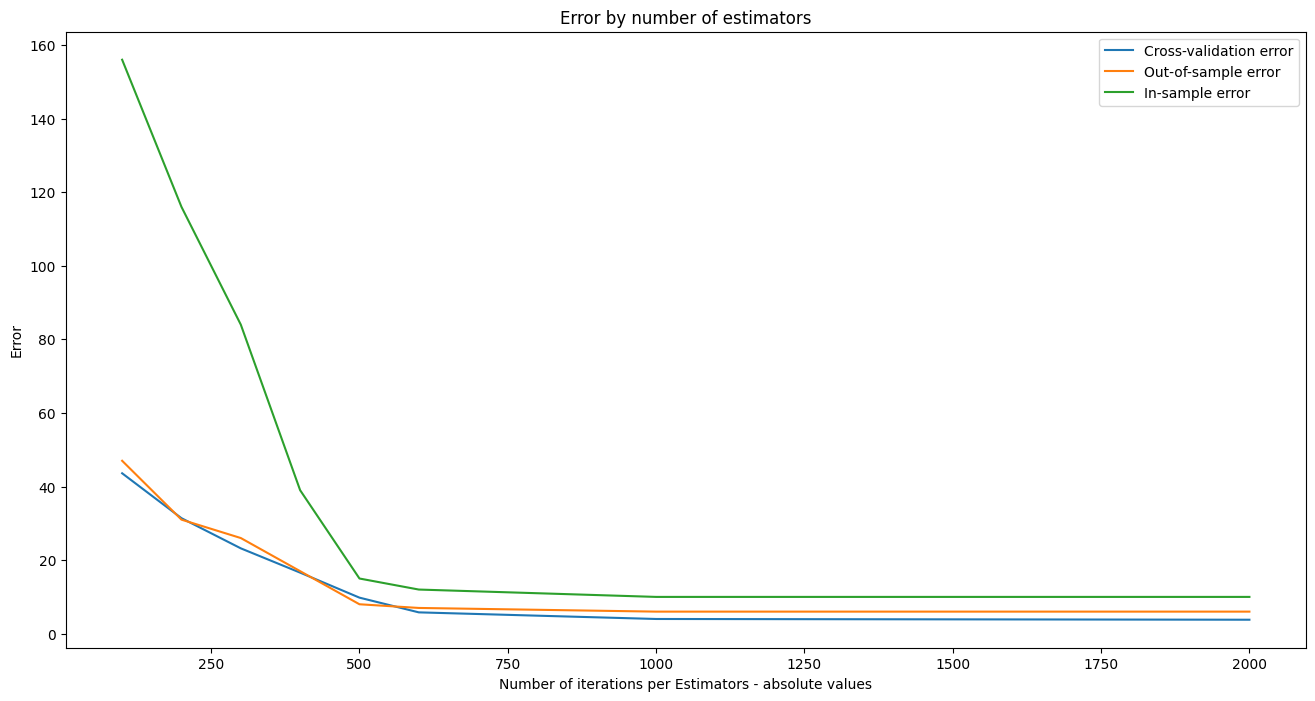

In [170]:
plt.figure(figsize=(16, 8))
plt.plot(estimatorsList, E_cv, label='Cross-validation error')
plt.plot(estimatorsList, E_out, label='Out-of-sample error')
plt.plot(estimatorsList, E_in, label='In-sample error')
plt.title('Error by number of estimators')
plt.xlabel('Number of iterations per Estimators - absolute values')
plt.ylabel('Error')
plt.legend()
plt.show()

### Análise dos Erros observados

O experimento realizado consiste em avaliar três tipos distintos de erro: in-sample (Ein), out-of-sample (Eout) e o de cross-valdation (Ecv). Primeiramente, pode-se observar pelo gráfico que a validação cruzada - que aqui foi calculada utilizando-se 5 partições - é um bom meio de aproximar o erro para dados não vistos. Além disso, é notável que o modelo comete menos falhas à medida que o número de estimadores aumenta, o que é esperado, uma vez que ele se torna mais complexo e consegue se ajustar melhor aos dados. Isso, contudo, tem um limite e por volta de 600 stumps é perceptível uma estabilização e leve aumento do erro, o que pode ser um indicador de overfitting.

## Variar profundidade dos stumps
Como experimento complementar, foi variado o parâmetro `maxDepth` do classificador DecisionTreeClassifier, que é o stump utilizado no Adaboost. Os resultados obtidos são apresentados a seguir.

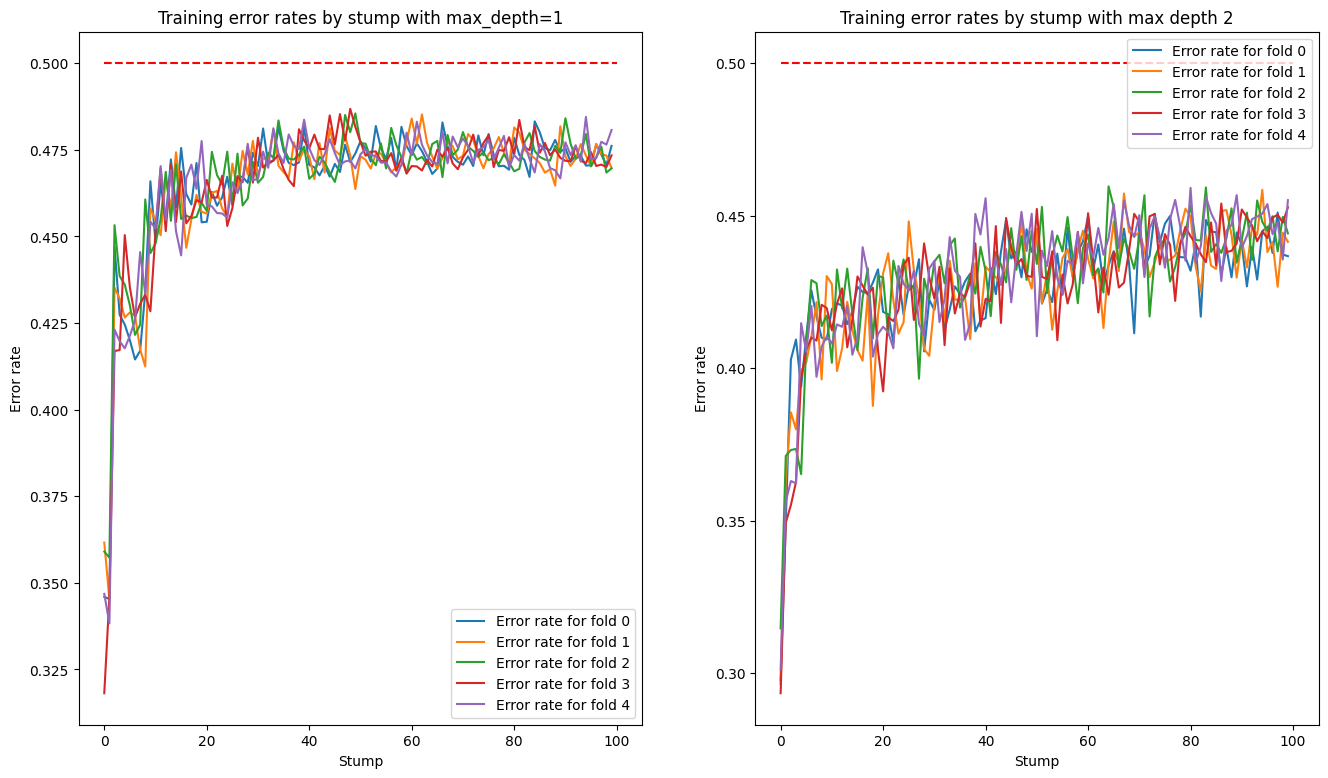

In [171]:
ada = AdaBoost()

fig, ax = plt.subplots(1, 2, figsize=(16, 9))

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    ax[0].plot(ada.errors, label=f'Error rate for fold {i}')

ax[0].hlines(0.5, 0, ada.nEstimators, colors = 'red', linestyles='dashed')
ax[0].set_title('Training error rates by stump with max_depth=1')
ax[0].set_xlabel('Stump')
ax[0].set_ylabel('Error rate')

ada = AdaBoost(DecisionTreeClassifier(max_depth=2))

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    ax[1].plot(ada.errors, label=f'Error rate for fold {i}')

ax[1].hlines(0.5, 0, ada.nEstimators, colors = 'red', linestyles='dashed')

ax[1].set_title('Training error rates by stump with max depth 2')
ax[1].set_xlabel('Stump')
ax[1].set_ylabel('Error rate')

ax[0].legend()
ax[1].legend()
plt.show()


Como já era esperado, os stumps com o menor grau de profundidade apresentam desempenho pouco melhor do que aquele observado ao se jogar uma moeda, com valores próximos a 50, porém com uma leve vantagem. O algotimo Adaboost se utiliza, então, do voto da maioria para chegar a uma classificação.

Pode-se perceber que as árvores mais profundas tendem a ter um desempenho melhor, o que é esperado, uma vez que elas conseguem capturar mais informações dos dados. Isso, no entanto, não é o suficiente para garantir um melhor desempenho do Adaboost, uma vez que o algoritmo tem a capacidade de se beneficiar de stumps mais fracos para garantir a generalização. A seguir analisaremos novamente os erros obtidos com os novos classificadores fracos.

In [172]:
ada = AdaBoost(DecisionTreeClassifier(max_depth=2))
E_cv = computeCrossValidationErrors(ada, X, y, nEstimators=100, k=5)

In [173]:
E_in = []
E_out = []

for estim in estimatorsList:
    e_in_, e_out_ = computeErrors(ada, X_train, X_test, y_train, y_test, nEstimators=estim)
    E_in.append(e_in_)
    E_out.append(e_out_)

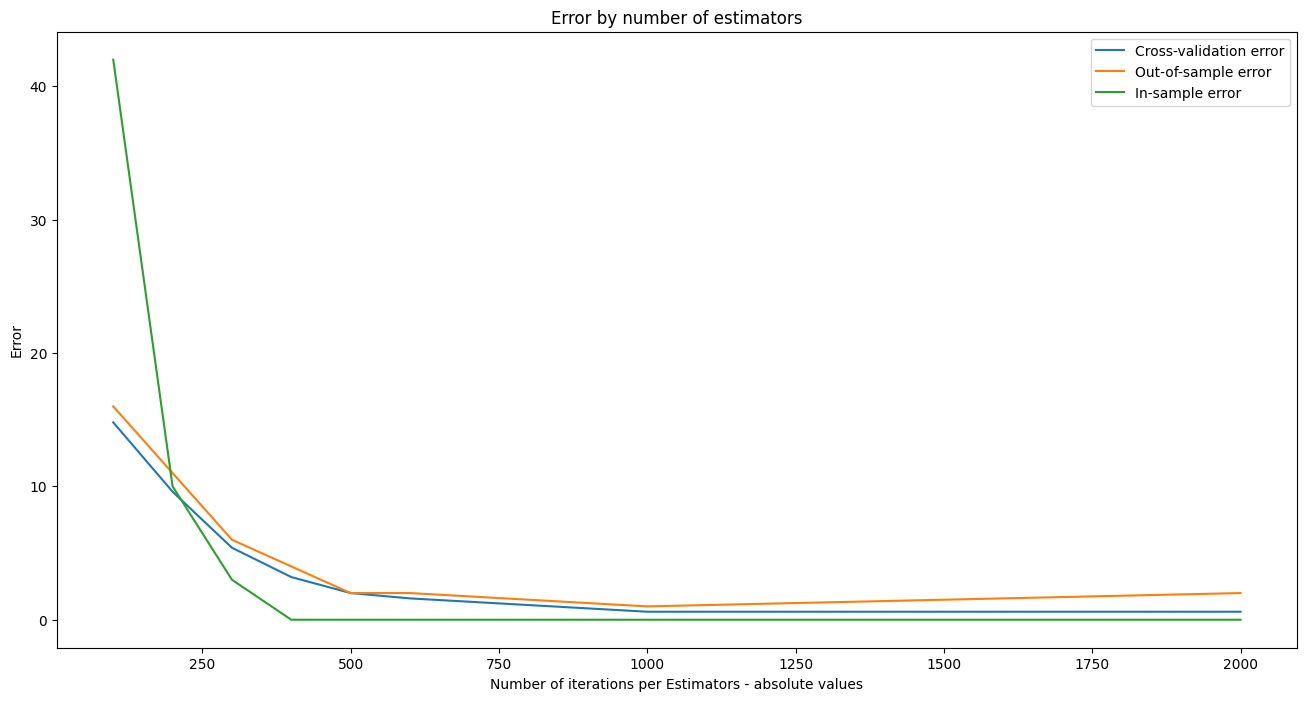

In [174]:
plt.figure(figsize=(16, 8))
plt.plot(estimatorsList, E_cv, label='Cross-validation error')
plt.plot(estimatorsList, E_out, label='Out-of-sample error')
plt.plot(estimatorsList, E_in, label='In-sample error')
plt.title('Error by number of estimators')
plt.xlabel('Number of iterations per Estimators - absolute values')
plt.ylabel('Error')
plt.legend()
plt.show()

### Análise dos Erros observados
Os erros para os stumps mais profundos são menores em geral, ainda que similares. Essa diferença é mais perceptível para o erro de treinamento, que se mantém próximo de 0 a partir de 400 stumps. Um fato interessante observável no gráfico é o aumento em Eout a partir de 1000 stumps, onde ele se distancia de Ecv e principalmente de Ein, o que indica um ponto de overfitting. A estabilização do Erro empírico com aumento do Erro esperado corrobora fortemente com essa afirmação.

# Conclusão
O algoritmo de Adaboost se mostrou eficaz para a classificação de dados, com uma taxa de erro que diminui à medida que o número de estimadores aumenta. O modelo, contudo, tem um limite e, após um certo número de stumps, começa a apresentar sinais de overfitting.

A validação cruzada usando 5 partições se mostrou um bom método para avaliar o erro esperado, dando uma noção razoável do desempenho para dados não vistos. Para além, pode-se considerar que o seu principal benefício foi observar o comportamento do erro conforme o ajuste do número de estimadores e a profundiade dos stumps, constituindo um meio confiável de se avaliar os parâmetros do modelo, de modo a poder ajustá-los mais apropriadamente.

A profundidade dos stumps, por sua vez, mostrou-se um fator importante para o desempenho do Adaboost, com stumps mais profundos apresentando um desempenho melhor. Esse fato, por outro lado, deve ser avaliado cuidadosamente, visto que a essa maior complexidade por levar a um overfitting do modelo.

Sendo assim, os parâmetros do modelo de Adaboost devem ser ajustados de forma a garantir um equilíbrio entre a capacidade de generalização e o desempenho, sempre levando em consideração a quantidade de dados disponíveis e a complexidade do problema. Todo o processo deve ser acompanhado cuidadosamente atrvés da validação cruzada para assegurar a confiabilidade dos resultados obtidos.